In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.signal import resample
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


from transformers import WhisperTokenizer
from transformers import WhisperFeatureExtractor
from transformers import WhisperForConditionalGeneration

import evaluate
#pip install jiwer

wer  = evaluate.load('wer')



def down_sample_audio(audio_original, original_sample_rate):
    target_sample_rate = 16000

    # Calculate the number of samples for the target sample rate
    num_samples = int(len(audio_original) * target_sample_rate / original_sample_rate)

    # Resample the audio array to the target sample rate
    downsampled_audio = resample(audio_original, num_samples)

    return downsampled_audio

In [12]:
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small",language='bengali',task='translate')
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small",language='bengali',task='translate')
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to('cuda')

In [29]:
from datasets import load_dataset,concatenate_datasets

asr_dataset = load_dataset("Mohan-diffuser/odia-english-ASR")

In [30]:
asr_dataset['train'][0]


{'id': 62,
 'num_samples': 159360,
 'path': '/home/mohan.dash/.cache/huggingface/datasets/downloads/extracted/e2fcce8118681935ebfe4ee7e9b039155b764427d2269ffa5a66a0328fe9ec55/10020140876560357327.wav',
 'audio': {'path': '10020140876560357327.wav',
  'array': array([ 0.        ,  0.        ,  0.        , ..., -0.00582969,
         -0.00332552, -0.00426018]),
  'sampling_rate': 16000},
 'transcription': 'ତାଙ୍କର 2 ଘଣ୍ଟାର ଭାଷଣରେ ସେ କହିଥିଲେ ଯେ ଆଜି apple ତାର ଫୋନକୁ ପୁଣି ଉଦ୍ଭାବନ କରିବାକୁ ଯାଉଛି ଆମେ ଆଜି ଇତିହାସ ରଚିବାକୁ ଯାଉଛୁ',
 'raw_transcription': 'ତାଙ୍କର 2 ଘଣ୍ଟାର ଭାଷଣରେ ସେ କହିଥିଲେ ଯେ "ଆଜି Apple ତାର ଫୋନକୁ ପୁଣି ଉଦ୍ଭାବନ କରିବାକୁ ଯାଉଛି, ଆମେ ଆଜି ଇତିହାସ ରଚିବାକୁ ଯାଉଛୁ।"',
 'gender': 1,
 'lang_id': 72,
 'language': 'Oriya',
 'lang_group_id': 4,
 'eng_translation': 'In his 2-hour speech, he said that today Apple is going to reinvent its phone. We are going to make history today.'}

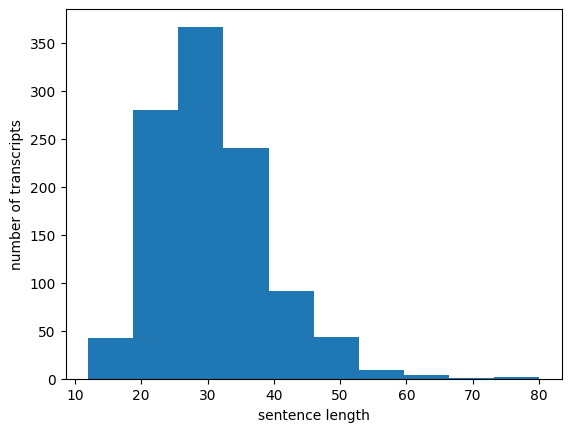

In [31]:
list_of_transcription_lengths = []

tokenized_text = tokenizer(asr_dataset['train']['eng_translation']).input_ids

for text in tokenized_text:
    list_of_transcription_lengths.append(len(text))
    # break

plt.hist(list_of_transcription_lengths)
plt.xlabel("sentence length")
plt.ylabel("number of transcripts")
plt.show()

In [32]:
import torch

for idx in range(5):

    target = asr_dataset['train'][idx]['eng_translation']
    audio_original = asr_dataset['train'][idx]['audio']['array']
    original_sample_rate = asr_dataset['train'][idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='translate')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : In his 2-hour speech, he said that today Apple is going to reinvent its phone. We are going to make history today. 
pred :  I have been in the forest for 2 hours and I am going to do some work on the water and the fire.

 
-------1------
true : The games started with good weather in the morning 10:00 and apart from a midnight thunderstorm which cleared up quickly it was a perfect day for 7th Rugby. 
pred :  The forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the heavy rain and the forest was completely destroyed by the he

In [33]:

class whisper_training_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len):#daatset is huggingface dataset object
        self.dataset = dataset
        self.max_len = max_len
        self.bos_token = model.config.decoder_start_token_id

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        audio_data = down_sample_audio(item['audio']["array"], item['audio']["sampling_rate"])
        input_features = feature_extractor(audio_data, sampling_rate=16000,return_tensors='pt').input_features[0]

        # Process the transcription
        transcription = item['eng_translation']

        # Create labels
        labels = tokenizer(transcription, padding="max_length", max_length=self.max_len, truncation=True, return_tensors="pt")
        labels = labels["input_ids"].masked_fill(labels['attention_mask'].ne(1), -100)
        labels = labels[0][1:]


        return {
            "input_features": input_features,
            "labels": labels
        }

In [34]:
dataset = whisper_training_dataset(dataset=asr_dataset['train'], max_len=60)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=8,  # Adjust batch size as needed
    shuffle=True,  # Shuffle data during training
)

In [42]:
def evaluation(model):

    device='cuda'

    test_dataset = whisper_training_dataset(dataset=asr_dataset['validation'], max_len=60)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=8,  # Adjust batch size as needed
        shuffle=True,  # Shuffle data during training
    )

    model.eval()

    predictions=[]
    references=[]

    for batch in tqdm(test_dataloader,total=len(test_dataloader)):
        

        model.eval()  # Set model to training mode
        model.config.use_cache = True

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        with torch.no_grad():
            generated_tokens = model.generate(input_features=input_features,language='bengali', task='translate')
                        
        decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

    WER = wer.compute(predictions=predictions, references=references) * 100

    return WER

In [ ]:
# WER before the training
torch.cuda.empty_cache()
evaluation(model)

 59%|█████▉    | 29/49 [02:21<01:53,  5.68s/it]

In [ ]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

config = LoraConfig(r=32, lora_alpha=32, target_modules=["q_proj", "v_proj", "q_proj", "out_proj"], lora_dropout=0.05, bias="none")

model = get_peft_model(model, config)
model.print_trainable_parameters()

# model.save_pretrained('lora_model')

# model = PeftModel.from_pretrained(model,model_id='lora_model')

# for n,p in model.named_parameters():
#     print(n,p.requires_grad)

# Filter parameters with requires_grad=True
requires_grad_params = filter(lambda x: x[1].requires_grad, model.parameters())

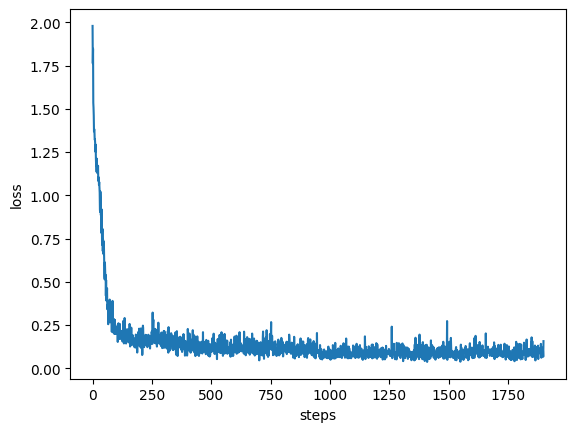

100%|██████████| 87/87 [05:47<00:00,  3.99s/it]  


In [ ]:
from IPython.display import clear_output
torch.cuda.empty_cache()

model.config.use_cache = False
model.train()

device='cuda'

optimizer=torch.optim.AdamW(model.parameters(), lr=1e-5)
# optimizer=torch.optim.AdamW(requires_grad_params, lr=5e-4) # Only for LoRA Training

max_epochs=2


running_wer=[]
running_loss=[]



for epoch in range(max_epochs):

    for batch in tqdm(train_dataloader,total=len(train_dataloader),leave=False):

        model.train()  # Set model to training mode

        input_features, labels = batch["input_features"].to(device), batch["labels"].to(device)

        # Forward pass
        outputs = model(input_features, labels=labels)  # Assuming your model takes these inputs
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients

        running_loss.append(loss.item())

        if len(running_loss) % 50 ==0:  # Print loss every 50 batches
            plt.plot(running_loss)
            plt.xlabel('steps')
            plt.ylabel('loss')
            clear_output(wait=True)  # Clear the output to keep the plot clean
            plt.show()

        if len(running_loss) % 100 == 0:  # Save model every 100 steps
            # torch.save(model.state_dict(), f'finetuned_on_odia_steps_{len(running_loss)}.pth')
            model.save_pretrained('lora_model')

    torch.cuda.empty_cache()
    running_wer.append(evaluation(model))
    


In [19]:
model.load_state_dict(torch.load('finetuned_on_odia_steps_1000.pth', weights_only=True))# loading the model
model.eval()
model.to('cuda')


torch.cuda.empty_cache()
evaluation(model)

100%|██████████| 87/87 [05:19<00:00,  3.67s/it]


41.10831234256927

In [ ]:
model.eval()

test_data = load_dataset("mozilla-foundation/common_voice_17_0", "or", split="test")

for idx in range(5):

    target = test_data[idx]['sentence']
    audio_original = test_data[idx]['audio']['array']
    original_sample_rate = test_data[idx]['audio']['sampling_rate']

    audio_16000 = down_sample_audio(audio_original, original_sample_rate)

    input_feature = feature_extractor(raw_speech=audio_16000,
                                    sampling_rate=16000,
                                    return_tensors='pt').input_features

    with torch.no_grad():
        op = model.generate(input_feature.to('cuda'), language='bengali', task='translate')


    text_pred =  tokenizer.batch_decode(op,skip_special_tokens=True )[0]

    print(f'-------{idx}------')
    print(f'true : {target} \npred : {text_pred}')
    print('\n ')

-------0------
true : ମଜଲିସ ଆଗରେ ଦର ଛିଣ୍ତିଲା ଅଢ଼େଇ ଟଙ୍କା । 
pred : ମଜଲିସ ଆଗରେ ଦର ଛଣ୍ଡିଲା ଅଢ଼େଇ ଟଙ୍କା ।

 
-------1------
true : ପହିଲୁ ପହିଲୁ କହିଲୁ, ପାଠ ପଢ଼ି ସାରିଲେ ବାହା ହେବୁ । 
pred : ପହିଲୁ, ପହିଲୁ, କହିଲୁ, ପାଠ ପଢ଼ି ସାରିଲେ ବାହା ହେବୁ ।

 
-------2------
true : ସେହି ଶବ୍ଦ ଶୁଣି ବିଲୁଆ ଧଡ଼ପଡ଼ ହୋଇ ପଳାଇଗଲା । 
pred : ସେହି ଶବ୍ଦ ଶୁଣି ବିଲ୍ଵା ଢ଼ ପଡ଼ ହୋଇ ପଳାଇଗଲା ।

 
-------3------
true : ଆପଣ ଛେଉଣ୍ଡଟିକୁ ଟିକିଏ ଦୟା କରନ୍ତୁ, ସେହି ପାଞ୍ଚଶରେ ମଙ୍ଗି ଯାନ୍ତୁ । 
pred : ଆପଣ ଅ ଛେଉଁଟଟିକୁ ଉଟିକେ ଦୟାକରନ୍ତ ସେଇ ପାଚାଷରେ ପଙ୍କି ଯେନ୍ଥୁ ।

 
-------4------
true : ଛଅ 
pred : ଛଅ

 


In [19]:
from transformers import pipeline

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=tokenizer,
    feature_extractor=feature_extractor,
    chunk_length_s=30, 
    stride_length_s=10, 
    device='cuda',
)

In [20]:
result = pipe("odia_audio_youtube.mp3")
result

c:\Users\User\miniconda3\envs\torch_env\Lib\site-packages\transformers\models\whisper\generation_whisper.py:509: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.


{'text': 'କ୍ୟାଦେକୁଛନ୍ତି ଗୋଟଉଛି କଲମ ଗୋଟଉଛି ରୁମାଲ ଗୋଟଉଛି ଘଣ୍ତା, ଏଇ ତିନିଟା ଭୁଲେ ମଧ୍ୟ କାରୁ ଗିଥ୍ଣେବେନି କି ଗିଥିପ୍ଥିବ୍ତି ଘିଥିପ୍ଥିନି କିଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥିପ୍ଥନେଇ ଯାଉଛନ୍ତି, ସେଇଟା ଆପଣଙ୍କର ଗୁର୍ ଗୁର୍ଲକ୍ ମାନେ ଭଲାର ଭଲେର ଆପଣଙ୍କର କାହାକୁ ଦେଇ ଦେଇ ଦେଇଦେବିଥିବେ ଦାନ ଅଲଗା ଦକେତିଣା ଲଗା, ଦକ୍ଷିଣା ମାନେ ତାଙ୍କୁ କହିଥାହୁ ଯେତେବିକୁ ଆମରକୁଣସି ପୂଜାପାଠ କରିଥାଉ ଆମରରନଣଭଭରାମଙ୍କୁ କିଛିଜୁର ଦେଇଥାହୁ ସେଟାହୁଛି ଦକିଛି ଆମରାମରଭ�ନ ବ୍ରାମଣଙ୍କୁ କିଛଦକ୍ଷିଣା ମାନେ ତାଙ୍କ ଦାନ କିଛି କର୍ମ କରେଇଲେ ଯେବାପଳରେ ଆମେ ତାଙ୍କୁ କିଛି ପ୍ରାପ୍ୟ ସେଉମ୍ଧାଇ ଦେଲେ କିନ୍ତୁ ଦାନଟାହୁଇଛି ସମ୍ପୂନ ଅଲୋଗା, ଆମର ବେଳବେବେକଣ ହେର ଆନଭେଲେ ଆପଣିଥିବିବିବିବିବିବିବି'}